In [ ]:
import sys
sys.path.append('../..')
from utils.workflow import WorkflowModel
from utils.data import RK4DataGenerator, stack_real_values, mono_beta, sin_beta
import utils.plotting as plotting
from utils.eval import eval_predictions, format_latex_table
import numpy as np
from scipy.stats import pearsonr, spearmanr

2026-01-31 15:37:57.362202: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-31 15:37:57.426305: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-31 15:37:58.998166: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Set the default float type to float64


E0000 00:00:1769884680.802732  403457 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1769884680.812580  403457 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
t_0, t_f, N = 0, 50, 100 
nop_data = t_f + 1
S0, I0, R0 = 99, 1, 0
noise_std = N * 0.00
test_t = np.linspace(t_0, t_f, nop_data)
rkdata = RK4DataGenerator(sin_beta, 
    t_0=t_0, 
    t_f=t_f, 
    N=N, 
    S0=S0, I0=I0, R0=R0
)
sir_real = rkdata.generate(test_t)
sir_data = rkdata.generate(test_t, noise_std)

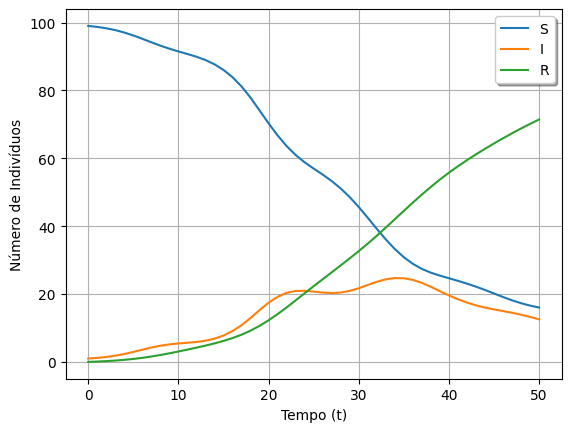

In [3]:
plotting.plot_rk_curves(test_t, sir_real)

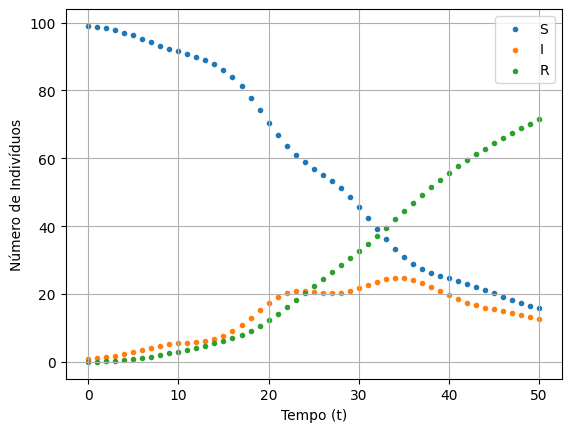

In [4]:
plotting.plot_rk_data(test_t, sir_data)

In [5]:
model = WorkflowModel(t_0, t_f, sir_data[:,1], test_t,
    N=N,
    beta_estimation_window=2,
    hidden_layer_size=10,
    n_hidden_layers=3,
    w_physics=4000,
    scaling="min/max",
    activation="tanh",
    adam_iterations=300000,
    estimate_beta=False,
    early_stopping=False,
    beta_hard_constraints=False,
    adaptative_wdata=False,
    fine_tunning_using_lbfgs=False)
model.S0, model.I0, model.beta0

Compiling model...
'compile' took 0.004832 s



(np.float64(4.178271800696817), np.float64(0.0), None)

In [6]:
model.train()

(<deepxde.model.LossHistory at 0x7fbd55e4ad50>,
 <deepxde.model.TrainState at 0x7fbd55e5a7d0>)

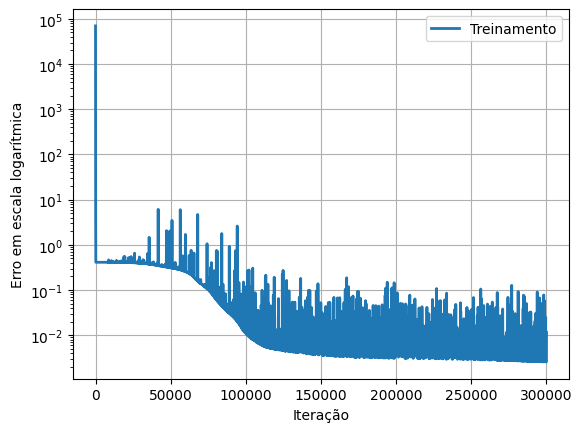

In [7]:
plotting.plot_losshistory(model.losshistory)

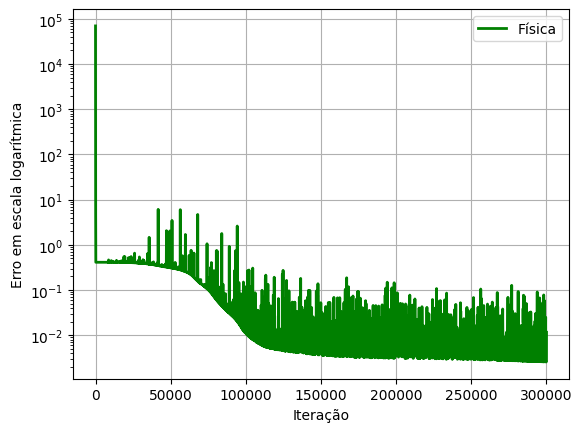

In [8]:
plotting.plot_phys_losshistory(model.losshistory)

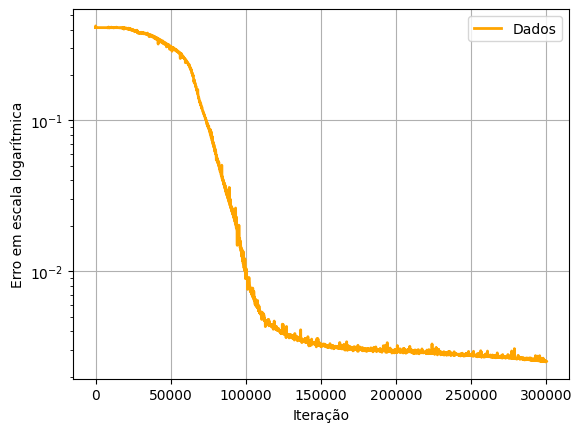

In [9]:
plotting.plot_data_losshistory(model.losshistory)

In [10]:
predictions = model.predict(test_t)

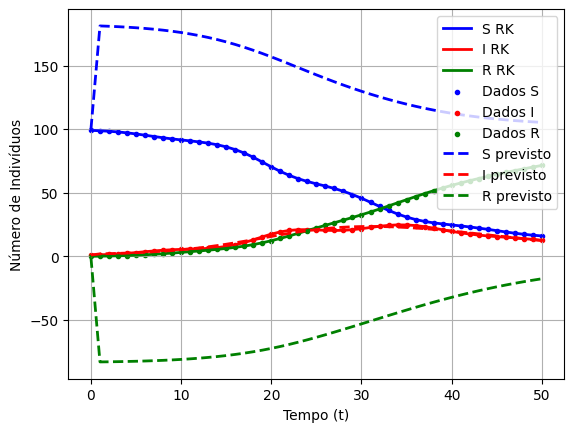

In [11]:
plotting.plot_results(sir_real, sir_data, predictions, test_t, N=N)

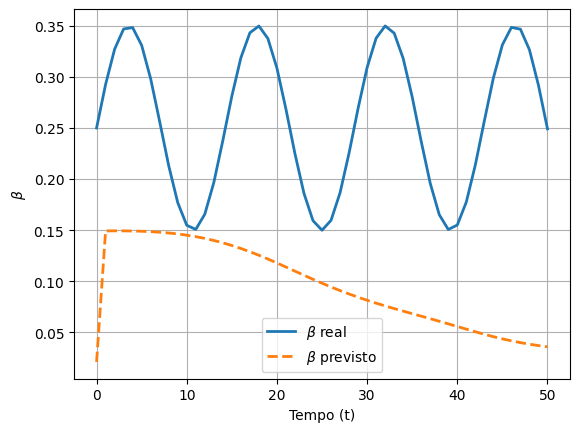

In [12]:
real_beta = sin_beta(test_t)
plotting.plot_beta_comparison(real_beta, predictions[:,2], test_t, 
    # vlines=[(30, "DFE", "red")], 
    # hlines=[(0.3, "min", "green"), (0.4, "max", "green")]
)

In [13]:
if model.data_weight_hist:
    plotting.plot_wdata(model.data_weight_hist)

In [14]:
real_values = stack_real_values(sir_real, real_beta)
predictions = eval_predictions(real_values, predictions)

In [15]:
predictions

,compartiment,RMSE,L2,L-infinity
0,S,84.925482,1.303537,89.241911
1,I,1.189623,0.073974,2.427504
2,beta,0.181634,0.677948,0.306576


In [ ]:
format_latex_table(predictions)

'\\begin{tabular}{llrrr}\n\\toprule\n & compartiment & RMSE & L2 & L-infinity \\\\\n\\midrule\n0 & S & 84.925482 & 1.303537 & 89.241911 \\\\\n1 & I & 1.189623 & 0.073974 & 2.427504 \\\\\n2 & beta & 0.181634 & 0.677948 & 0.306576 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [17]:
model.formated_total_training_time

'00:05:54'

In [18]:
temperature = np.linspace(1, 10, 50)
correlation_t = np.linspace(t_0, t_f, len(temperature))

In [19]:
temperature

array([ 1.        ,  1.18367347,  1.36734694,  1.55102041,  1.73469388,
        1.91836735,  2.10204082,  2.28571429,  2.46938776,  2.65306122,
        2.83673469,  3.02040816,  3.20408163,  3.3877551 ,  3.57142857,
        3.75510204,  3.93877551,  4.12244898,  4.30612245,  4.48979592,
        4.67346939,  4.85714286,  5.04081633,  5.2244898 ,  5.40816327,
        5.59183673,  5.7755102 ,  5.95918367,  6.14285714,  6.32653061,
        6.51020408,  6.69387755,  6.87755102,  7.06122449,  7.24489796,
        7.42857143,  7.6122449 ,  7.79591837,  7.97959184,  8.16326531,
        8.34693878,  8.53061224,  8.71428571,  8.89795918,  9.08163265,
        9.26530612,  9.44897959,  9.63265306,  9.81632653, 10.        ])

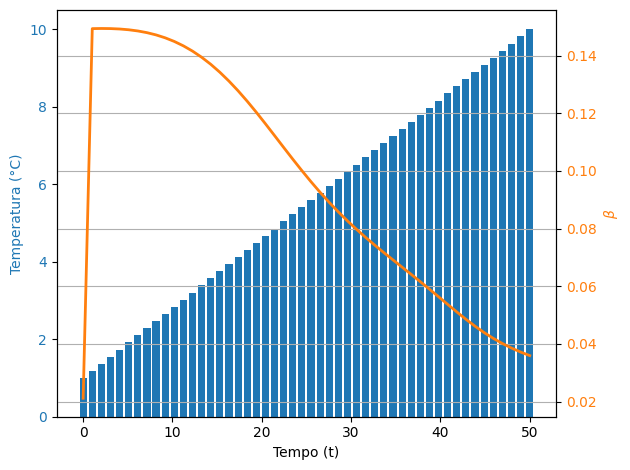

In [20]:
pred_beta_correlation = model.predict(correlation_t)[:,2]
plotting.plot_correlation(pred_beta_correlation, temperature, correlation_t, "Temperatura (°C)")

In [21]:
pearson_test = pearsonr(pred_beta_correlation, temperature)
pearson_test.statistic, pearson_test.pvalue

(np.float64(-0.8639385959535911), np.float64(6.601871520112696e-16))

In [22]:
spearman_test = spearmanr(pred_beta_correlation, temperature)
spearman_test.statistic, spearman_test.pvalue

(np.float64(-0.882064825930372), np.float64(2.6410852324346158e-17))